In [ ]:
# Train multiclass model for classification

import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import classification_report
import torch
import numpy as np

# 1. Load the dataset
df = pd.read_csv("reddit_sentiment_labeled_5000.csv")
label_map = {"Positive": 0, "Negative": 1, "Suggestion": 2, "Neutral": 3}
df["label"] = df["label"].map(label_map)

# 2. Convert to HuggingFace Dataset
dataset = Dataset.from_pandas(df[["text", "label"]])
dataset = dataset.train_test_split(test_size=0.2, seed=42)

# 3. Tokenize
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_fn(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

tokenized_ds = dataset.map(tokenize_fn, batched=True)

# 4. Load Model
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

# 5. TrainingArguments
training_args = TrainingArguments(
    output_dir="./bert-multiclass-results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

# 6. Evaluation Metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    report = classification_report(labels, preds, target_names=list(label_map.keys()), output_dict=True)
    return {
        "accuracy": report["accuracy"],
        "f1_positive": report["Positive"]["f1-score"],
        "f1_negative": report["Negative"]["f1-score"],
        "f1_suggestion": report["Suggestion"]["f1-score"],
        "f1_neutral": report["Neutral"]["f1-score"]
    }

# 7. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# 8. Train
trainer.train()

# 9. Save model
trainer.save_model("./bert-multiclass-model")
tokenizer.save_pretrained("./bert-multiclass-model")


Map:   0%|          | 0/4020 [00:00<?, ? examples/s]

Map:   0%|          | 0/1006 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/w4/fvh2x8gx6639vy7vkjnqzs1w0000gn/T/ipykernel_1633/844038094.py:59: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss


In [9]:
import praw
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
import gensim
from gensim import corpora
from gensim.models import LdaMulticore
from transformers import pipeline
import numpy as np
from minisom import MiniSom  # pip install minisom
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import os
import pandas as pd

In [12]:
def initialize_nlp():
    nlp = spacy.load("en_core_web_sm")
    nltk.download("stopwords")
    nltk.download("punkt")
    return nlp

def get_reddit_posts(cache_path="reddit_buyitforlife_posts.csv"):
    if os.path.exists(cache_path):
        print(" Loading posts from cached CSV...")
        df = pd.read_csv(cache_path)
        posts = list(zip(df["title"], df["body"]))
    else:
        print(" Fetching posts from Reddit API...")
        reddit = praw.Reddit(
            client_id="9ETAXWFx9IHiC7AOh8-APg",
            client_secret="TuskU4_ysvTwaJJ3i9K40HLEiykE9A",
            user_agent="python:brand-sentiment-analyzer:v1.0 (by /u/Soul_Pay4951)"
        )
        subreddit = reddit.subreddit("buyitforlife")
        posts = []
        for post in subreddit.hot(limit=50):
            post.comments.replace_more(limit=0)
            comments = [comment.body for comment in post.comments.list()]
            top_comments = " ".join(comments[:3])  # optional
            title = post.title.strip()
            body = (post.selftext + " " + top_comments).strip()
            posts.append((title, body))

        # Save to CSV
        df = pd.DataFrame(posts, columns=["title", "body"])
        df.to_csv(cache_path, index=False)
        print(f" Saved {len(posts)} posts to {cache_path}")

    return posts


def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # Remove URLs
    text = re.sub(r"\W", " ", text)  # Remove special characters
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words("english")]
    return " ".join(tokens)

def preprocess_for_lda(text, stop_words):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words and word.isalpha()]
    return tokens

def extract_entities(text, nlp):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents if ent.label_ in ["ORG", "PRODUCT"]]

def perform_topic_modeling(tokenized_posts, num_topics=3):
    dictionary = corpora.Dictionary(tokenized_posts)
    corpus = [dictionary.doc2bow(post) for post in tokenized_posts]
    lda_model = LdaMulticore(
        corpus,
        num_topics=num_topics,
        id2word=dictionary,
        passes=10,
        workers=2
    )
    topics = lda_model.print_topics(num_words=5)
    return topics, lda_model, corpus, dictionary


import torch
import torch.nn.functional as F

# load pretrained model
tokenizer = AutoTokenizer.from_pretrained("./bert-multiclass-model")
model = AutoModelForSequenceClassification.from_pretrained("./bert-multiclass-model")

# Make sure this matches your model's class mapping
label_map = {
    0: "POSITIVE",
    1: "NEGATIVE",
    2: "SUGGESTION"
}

def analyze_multiclass_sentiments(texts):
    results = []

    for text in texts:
        # Tokenize the input text
        inputs = tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=512  
        )

        # Move tensors to the same device as the model
        inputs = {k: v.to(model.device) for k, v in inputs.items()}

        # Inference
        with torch.no_grad():
            outputs = model(**inputs)
            probs = F.softmax(outputs.logits, dim=1)

        predicted_class = torch.argmax(probs, dim=1).item()
        label = label_map[predicted_class]
        score = probs[0][predicted_class].item()

        results.append({
            "label": label,
            "score": round(score, 4)  # Rounded for cleaner output
        })

    return results



In [13]:
from collections import defaultdict

def get_suggestions_by_org(cleaned_posts, sentiments, entity_lists):
    suggestions_by_org = defaultdict(list)
    for (title, body), sentiment, entities in zip(cleaned_posts, sentiments, entity_lists):
        if sentiment['label'] == 'SUGGESTION' and sentiment['score'] > 0.85:
            text = title + " " + body
            for entity, ent_type in entities:
                if ent_type == "ORG":
                    suggestions_by_org[entity].append(text)
    return suggestions_by_org


In [14]:
# Simplified Hebbian Learning simulation: updating an association score for each topic.
class HebbianLearning:
    def __init__(self, topics):
        self.topics = topics
        self.associations = {topic: 0.0 for topic in topics}

    def update(self, topic, sentiment_score):
        learning_rate = 0.1
        if topic in self.associations:
            self.associations[topic] += learning_rate * sentiment_score

    def get_associations(self):
        return self.associations

# Self-Organizing Maps (SOM) for clustering sentiment trends.
def cluster_sentiments(senti_vectors):
    if not senti_vectors:
        return None
    data = np.array(senti_vectors)
    # Initialize a SOM with a 3x3 grid.
    som = MiniSom(3, 3, data.shape[1], sigma=0.5, learning_rate=0.5, random_seed=42)
    som.random_weights_init(data)
    som.train_random(data, 100)
    # For each sentiment vector, determine its winning node (cluster).
    clusters = [som.winner(vec) for vec in data]
    return clusters

In [15]:
#visualize SOM
from sklearn.metrics import silhouette_score
import numpy as np

def visualize_som_silhouette(senti_vectors, clusters):
    if not senti_vectors or not clusters:
        print("SOM: Insufficient data for silhouette score.")
        return None

    data = np.array(senti_vectors)
    labels = [f"{c[0]}-{c[1]}" for c in clusters]
    try:
        sil_score = silhouette_score(data, labels)
    except:
        sil_score = 0

    print(f"SOM Silhouette Score: {sil_score:.4f}")
    plt.figure(figsize=(6, 4))
    plt.bar(['SOM Clustering'], [sil_score], color='darkorange')
    plt.ylabel("Silhouette Score")
    plt.title("SOM Cluster Quality")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()
    return sil_score


In [16]:
#transformers performance
from sklearn.metrics import classification_report

def visualize_transformer_performance(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True)
    accuracy = report['accuracy']
    f1_macro = report['macro avg']['f1-score']

    print(f"Transformer Accuracy: {accuracy:.4f}")
    print(f"Transformer F1 Score: {f1_macro:.4f}")

    labels = ['Accuracy', 'F1 Score']
    values = [accuracy, f1_macro]

    plt.figure(figsize=(6, 4))
    plt.bar(labels, values, color='mediumseagreen')
    plt.ylim(0, 1)
    plt.title("Transformer Performance")
    for i, v in enumerate(values):
        plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
    plt.tight_layout()
    plt.show()
    return accuracy, f1_macro


In [17]:
def visualize_method_comparison(lda_score, som_score, transformer_score):
    methods = ['LDA', 'SOM', 'Transformer']
    scores = [lda_score, som_score, transformer_score]

    plt.figure(figsize=(8, 5))
    bars = plt.bar(methods, scores, color=['cornflowerblue', 'darkorange', 'mediumseagreen'])
    plt.ylabel('Evaluation Metric (Scaled 0-1)')
    plt.title('Method Comparison: Insight Value / Quality Metric')
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.2f}", ha='center')
    plt.ylim(0, 1.1)
    plt.tight_layout()
    plt.show()


In [18]:
#Execute

nlp = initialize_nlp()
posts = get_reddit_posts()

# Clean posts (title and selftext)
cleaned_posts = [(clean_text(title), clean_text(body)) for title, body in posts]
print("Cleaned Posts:")
for cp in cleaned_posts:
    print(cp)

# Extract entities (e.g., brands, products) using NER
brands_products = [extract_entities(title + " " + body, nlp) for title, body in cleaned_posts]
print("\nExtracted Entities (Brands/Products):")
for bp in brands_products:
    print(bp)

# Preprocess text for LDA topic modeling
stop_words = set(stopwords.words("english"))
tokenized_posts = [preprocess_for_lda(title + " " + body, stop_words) for title, body in cleaned_posts]
topics, lda_model, corpus, dictionary = perform_topic_modeling(tokenized_posts, num_topics=3)
print("\nTopics from LDA:")
for topic in topics:
    print(topic)

# --- Sentiment Analysis ---
combined_texts = [title + " " + body for title, body in cleaned_posts]
sentiments = analyze_multiclass_sentiments(combined_texts)
print("\nMulticlass Sentiments:")
for sentiment in sentiments:
    print(sentiment)

# --- Hebbian Learning ---
topic_strs = [t[1] for t in topics]
hebbian = HebbianLearning(topic_strs)
for res in sentiments:
    score = res['score'] if res['label'] == "positive" else -res['score']
    for topic in topic_strs:
        hebbian.update(topic, score)
associations = hebbian.get_associations()
print("\nHebbian Associations:")
for topic, assoc in associations.items():
    print(f"{topic}: {assoc:.4f}")

# --- SOM Sentiment Vectors (3-class) ---
senti_vectors = []
for res in sentiments:
    if res['label'] == "positive":
        senti_vectors.append([res['score'], 0.0, 0.0])
    elif res['label'] == "negative":
        senti_vectors.append([0.0, res['score'], 0.0])
    else:  # suggestion
        senti_vectors.append([0.0, 0.0, res['score']])
clusters = cluster_sentiments(senti_vectors)
print("\nSOM Clusters:")
print(clusters)





[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vineethmariappan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/vineethmariappan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


 Fetching posts from Reddit API...
 Saved 50 posts to reddit_buyitforlife_posts.csv
Cleaned Posts:
('buyitforlife canada favourite things made canada', 'starting trade war us canada feel best us north support local ever one favourite clothing brands anian victoria bc shirts probably end getting edit adding brands personally love canada west boots made winnipeg wearing pair romeos couple years popov leather made nelson bc leather goods holding really well meyer pei high quality made canada pots pans non stick 12 abusing mod powers sticky post also mention another great subreddit r buycanadian lee valley hands stuff legit meyer stainless steel cookware manufactured pei mine three years definitely feel like bifl quality')
('list bifl made usa', 'timely reminder subreddit obviously usa centric recommendations majority users often leads people realising comparable better items found closer home easier cheaper free tolls thought would good idea crowdsource manufacturers non american users ne

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



Topics from LDA:
(0, '0.010*"one" + 0.009*"quality" + 0.007*"looking" + 0.007*"leather" + 0.006*"like"')
(1, '0.015*"leather" + 0.008*"use" + 0.006*"used" + 0.006*"years" + 0.006*"looking"')
(2, '0.008*"good" + 0.007*"like" + 0.007*"work" + 0.007*"uk" + 0.006*"years"')

Multiclass Sentiments:
{'label': 'POSITIVE', 'score': 0.4602}
{'label': 'POSITIVE', 'score': 0.464}
{'label': 'NEGATIVE', 'score': 0.8307}
{'label': 'NEGATIVE', 'score': 0.519}
{'label': 'SUGGESTION', 'score': 0.7788}
{'label': 'NEGATIVE', 'score': 0.8549}
{'label': 'SUGGESTION', 'score': 0.8049}
{'label': 'SUGGESTION', 'score': 0.7978}
{'label': 'NEGATIVE', 'score': 0.9944}
{'label': 'SUGGESTION', 'score': 0.9926}
{'label': 'SUGGESTION', 'score': 0.9309}
{'label': 'SUGGESTION', 'score': 0.5237}
{'label': 'NEGATIVE', 'score': 0.8427}
{'label': 'POSITIVE', 'score': 0.6698}
{'label': 'NEGATIVE', 'score': 0.7469}
{'label': 'SUGGESTION', 'score': 0.9096}
{'label': 'NEGATIVE', 'score': 0.3948}
{'label': 'SUGGESTION', 'score

In [19]:
#summarize suggestions
import re
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

def summarize_suggestions(suggestions_by_org, num_summary_sentences=3):
    summary_by_org = {}

    for org, suggestions in suggestions_by_org.items():
        if not suggestions:
            continue

        # Clean and preprocess suggestions
        clean_suggestions = [re.sub(r'\s+', ' ', s.strip()) for s in suggestions]

        # Vectorize
        vectorizer = TfidfVectorizer(stop_words='english')
        X = vectorizer.fit_transform(clean_suggestions)

        # Cluster into a few themes
        n_clusters = min(3, len(clean_suggestions))
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(X)

        # Find representative suggestion from each cluster
        summary = []
        for i in range(n_clusters):
            cluster_indices = (kmeans.labels_ == i).nonzero()[0]
            if len(cluster_indices) > 0:
                first_comment = clean_suggestions[cluster_indices[0]]
                summary.append(first_comment)

        summary_by_org[org] = summary[:num_summary_sentences]

    return summary_by_org


In [20]:
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

def visualize_lda_coherence(lda_model, tokenized_posts, dictionary):
    coherence_model = CoherenceModel(model=lda_model, texts=tokenized_posts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    print(f"LDA Coherence Score: {coherence_score:.4f}")

    plt.figure(figsize=(6, 4))
    plt.bar(['LDA Topic Modeling'], [coherence_score], color='cornflowerblue')
    plt.ylabel("Coherence Score (c_v)")
    plt.title("LDA Coherence Score")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()
    return coherence_score


In [21]:
# --- Suggestions Per Organization ---
suggestions_by_org = get_suggestions_by_org(cleaned_posts, sentiments, brands_products)
print("\nSuggestions by Organization:")
for org, suggestions in suggestions_by_org.items():
    print(f"\n{org}:")
    for s in suggestions:
        print(f"  - {s}")
        
summarized = summarize_suggestions(suggestions_by_org)
print(summarized)
print("\nSummary of Suggestions by Organization:")
for org, summaries in summarized.items():
    print(f"\n{org}:")
    for s in summaries:
        print(f"  - {s}")



Suggestions by Organization:

slip steel:
  - slip steel toe work boots gotten 8 years wolverines looking get new pair slip safety requirement working water retiring soles go cobbler put new soles treat leather gives bit life otherwise look redwings catalog work boots good luck wolverine got bought back quality gone shit recent years seems like easy answer always redwing never understood works really like style friction boots day
{'slip steel': ['slip steel toe work boots gotten 8 years wolverines looking get new pair slip safety requirement working water retiring soles go cobbler put new soles treat leather gives bit life otherwise look redwings catalog work boots good luck wolverine got bought back quality gone shit recent years seems like easy answer always redwing never understood works really like style friction boots day']}

Summary of Suggestions by Organization:

slip steel:
  - slip steel toe work boots gotten 8 years wolverines looking get new pair slip safety requirement wo

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [1]:
# from transformers import pipeline

# # Load your trained model
# sentiment_pipeline = pipeline("text-classification", model="./bert-multiclass-model", tokenizer="./bert-multiclass-model")

# def analyze_sentiments(texts):
#     sentiments = []
#     for text in texts:
#         result = sentiment_pipeline(text)[0]  # e.g., {'label': 'LABEL_2', 'score': 0.92}
#         label = result['label']
#         label_map = {'LABEL_0': 'POSITIVE', 'LABEL_1': 'NEGATIVE', 'LABEL_2': 'SUGGESTION'}
#         sentiments.append({'label': label_map[label], 'score': result['score']})
#     return sentiments


Device set to use mps:0


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

LDA Coherence Score: 0.5005


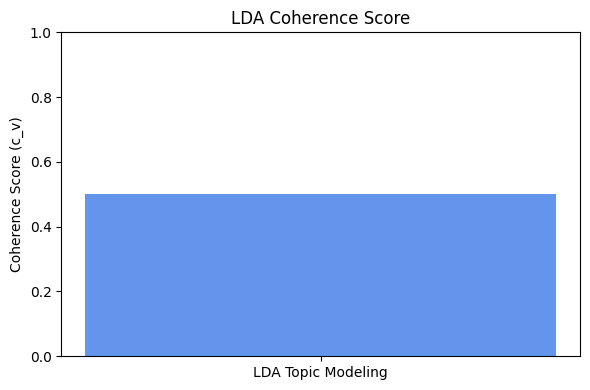

SOM Silhouette Score: 0.6311


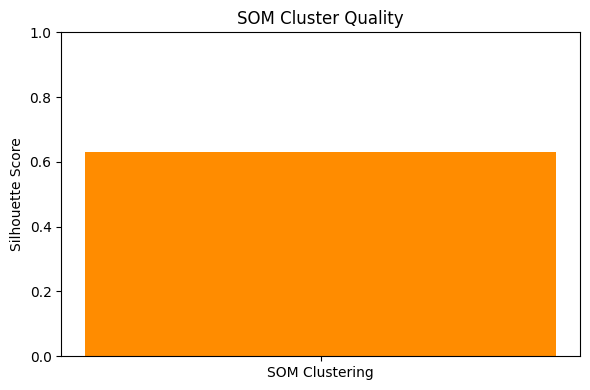

In [12]:
lda_score = visualize_lda_coherence(lda_model, tokenized_posts, dictionary)
som_score = visualize_som_silhouette(senti_vectors, clusters)


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use mps:0


Transformer Accuracy: 0.6665
Transformer F1 Score: 0.5351


/opt/anaconda3/envs/ai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/ai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/ai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


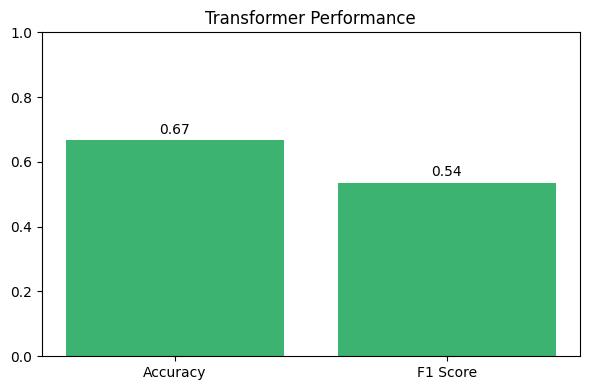

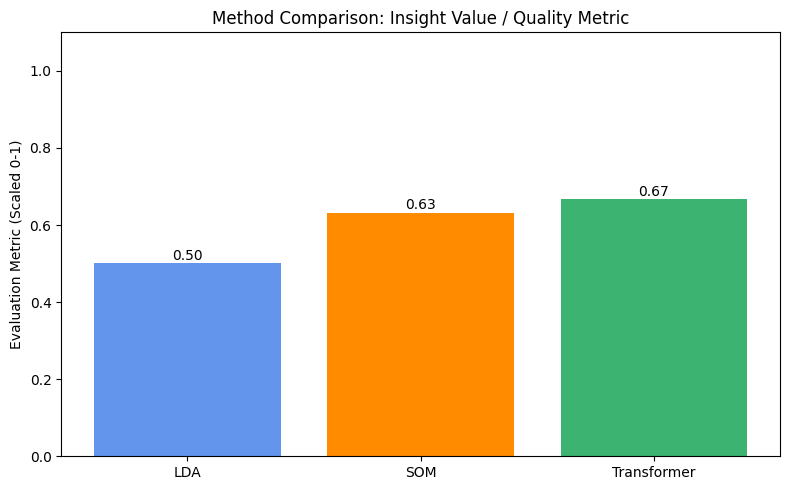

In [13]:
#remove this code- its outdated
import pandas as pd
from transformers import pipeline

# Load test data
df = pd.read_csv("sentiment_test_10000_final.csv")
texts = df["text"].tolist()
y_true = df["label"].tolist()

# Predict using transformer model
sentiment_pipeline = pipeline("sentiment-analysis")
y_pred = []

for text in texts:
    result = sentiment_pipeline(text)[0]["label"].lower()
    if result == "positive":
        y_pred.append("positive")
    else:
        y_pred.append("negative")  # or "suggestion" if you're handling that

# Now call the visualization
transformer_accuracy, transformer_f1 = visualize_transformer_performance(y_true, y_pred)

visualize_method_comparison(lda_score, som_score, transformer_accuracy)